## 手动实现LSTM（传统实现）

In [1]:
import math

import torch
from torch import nn
import numpy as np

from datasets import *

In [2]:
class My_legacyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.w_f = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_f = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_f = nn.Parameter(torch.zeros(hidden_size))

        self.w_i = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_i = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_i = nn.Parameter(torch.zeros(hidden_size))

        self.w_o = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_o = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_o = nn.Parameter(torch.zeros(hidden_size))

        self.w_c = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_c = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_c = nn.Parameter(torch.zeros(hidden_size))

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)

        # 需要初始化隐藏状态和细胞状态
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        c = torch.zeros(batch_size, self.hidden_size).to(x.device)
        y_list = []
        for i in range(seq_len):
            forget_gate = self.sigmoid(torch.matmul(x[:, i, :], self.w_f) +
                                       torch.matmul(h, self.u_f) + self.b_f)
            # (batch_siz,hidden_size)
            input_gate = self.sigmoid(torch.matmul(x[:, i, :], self.w_i) +
                                      torch.matmul(h, self.u_i) + self.b_i)
            output_gate = self.sigmoid(torch.matmul(x[:, i, :], self.w_o) +
                                       torch.matmul(h, self.u_o) + self.b_o)
            # 这里可以看到各个门的运作方式。
            # 三个门均通过hadamard积作用在每一个维度上。
            c = forget_gate * c + input_gate * self.tanh(torch.matmul(x[:, i, :], self.w_c) +
                                                         torch.matmul(h, self.u_c) + self.b_c)
            h = output_gate * self.tanh(c)
            y_list.append(h)
        return torch.stack(y_list, dim=1), (h, c)

In [3]:
##第二部分：加载数据集，生成迭代器
KrakowData = KrakowDataset()
train_set, val_set, test_set = KrakowData.construct_set(0.6, 0.2)

batch_size = 64
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
val_loader = data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
test_loader = data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
train_loader

In [4]:
##第三部分：测试指标RMSE、MAE和MAPE
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [8]:
#第四部分：模型初始化并进行训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 1
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_lstm_lega = My_legacyLSTM(input_size, hidden_size).to(device)

optimizer = torch.optim.Adam(my_lstm_lega.parameters(), lr)

In [9]:
from utils import *

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_lstm_lega, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch5, train loss 0.0363, train rmse 54.4267, val loss 0.0292, val rmse 48.197516, time use 2.215s
*** epoch10, train loss 0.0288, train rmse 48.2680, val loss 0.0184, val rmse 37.805469, time use 2.279s
*** epoch15, train loss 0.0234, train rmse 43.3336, val loss 0.0113, val rmse 29.199000, time use 2.213s
*** epoch20, train loss 0.0198, train rmse 39.9033, val loss 0.0071, val rmse 22.696713, time use 2.212s
*** epoch25, train loss 0.0170, train rmse 36.8808, val loss 0.0048, val rmse 18.307460, time use 2.272s
*** epoch30, train loss 0.0146, train rmse 34.0066, val loss 0.0037, val rmse 15.872321, time use 2.509s
*** epoch35, train loss 0.0126, train rmse 31.4650, val loss 0.0032, val rmse 14.803159, time use 2.309s
*** epoch40, train loss 0.0107, train rmse 29.2854, val loss 0.0029, val rmse 14.345604, time use 2.194s
*** epoch45, train loss 0.0092, train rmse 26.9906, val loss 0.0028, val rmse 14.024835, time use 2.235s
*** epoch50, train loss 0.0080, train rmse 25.2679, val 

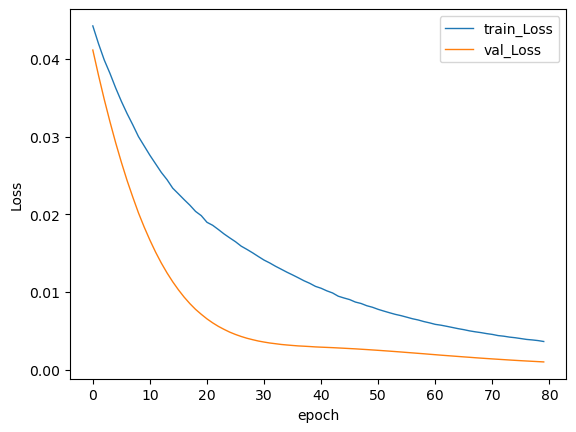

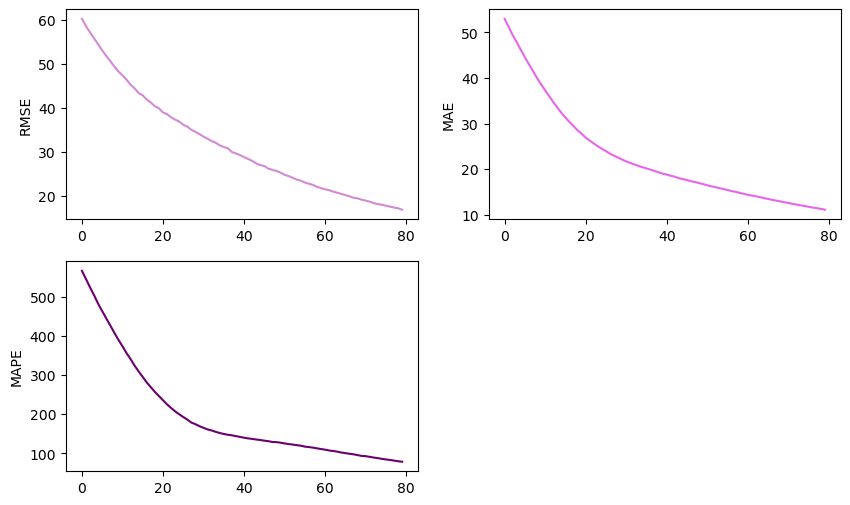

In [11]:
#第五部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## 手动实现LSTM（现代实现）

In [12]:
## 第一部分：定义网络
class My_LSTM(nn. Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gates = nn.Linear(input_size + hidden_size, hidden_size * 4)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn. Tanh()
        self.output = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h, c = (torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(2))
        y_list = []
        for i in range(seq_len):
            forget_gate, input_gate, output_gate, candidate_cell = \
                self.gates(torch.cat([x[:, i, :], h], dim=-1)).chunk(4, -1)
            forget_gate, input_gate, output_gate = (self.sigmoid(g)
                                                    for g in (forget_gate, input_gate, output_gate))
            c = forget_gate * c + input_gate * self.tanh(candidate_cell)
            h = output_gate * self.tanh(c)
            y_list.append(self.output(h))
        return torch.stack(y_list, dim=1), (h, c)

In [16]:
#第二部分：模型初始化并进行训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

my_lstm_modern = My_LSTM(input_size, hidden_size,output_size).to(device)

optimizer = torch.optim.Adam(my_lstm_modern.parameters(), lr)

In [17]:
from utils import *

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(my_lstm_modern, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=None)

*** epoch5, train loss 0.0024, train rmse 13.6594, val loss 0.0002, val rmse 3.769414, time use 1.526s
*** epoch10, train loss 0.0018, train rmse 11.5240, val loss 0.0002, val rmse 3.492369, time use 1.574s
*** epoch15, train loss 0.0014, train rmse 10.3978, val loss 0.0001, val rmse 3.229485, time use 1.531s
*** epoch20, train loss 0.0012, train rmse 9.7566, val loss 0.0001, val rmse 3.088673, time use 1.618s
*** epoch25, train loss 0.0011, train rmse 9.0903, val loss 0.0001, val rmse 3.159984, time use 1.562s
*** epoch30, train loss 0.0010, train rmse 8.7342, val loss 0.0002, val rmse 3.647078, time use 1.555s
*** epoch35, train loss 0.0009, train rmse 8.4848, val loss 0.0001, val rmse 2.796864, time use 1.541s
*** epoch40, train loss 0.0009, train rmse 8.3406, val loss 0.0001, val rmse 3.448432, time use 1.542s
*** epoch45, train loss 0.0009, train rmse 8.4070, val loss 0.0001, val rmse 2.709705, time use 1.544s
*** epoch50, train loss 0.0009, train rmse 8.1450, val loss 0.0001, val

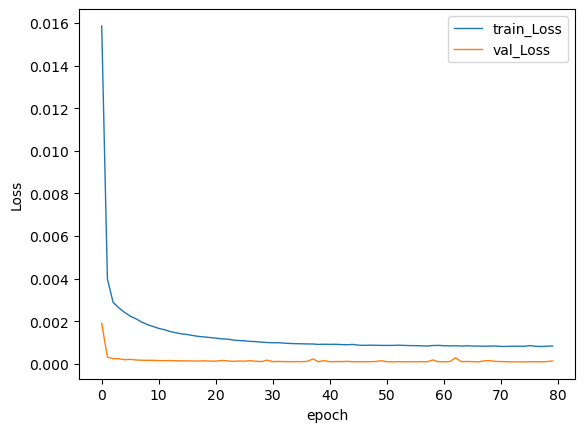

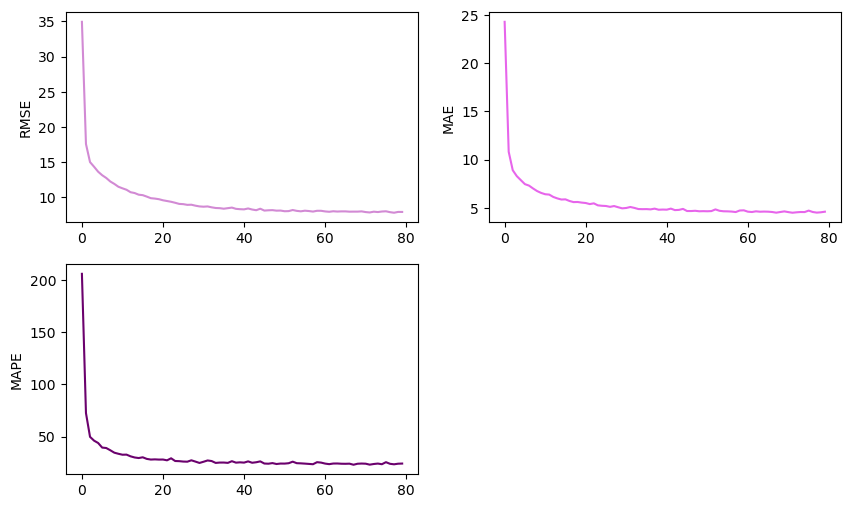

In [18]:
#第三部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)

## 调用torch.nn实现LSTM

In [8]:
#第一部分：调用LSTM并进行训练
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_set.X.shape[-1]
hidden_size = 64
output_size = 1
seq_len = 12
lr = 0.0001
epochs = 80
loss_func = nn.MSELoss()

nn_lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1, batch_first=True).to(device)
out_linear = nn.Sequential(nn.Linear(hidden_size, 1),
                           nn.LeakyReLU()).to(device)

optimizer = torch.optim.Adam(list(nn_lstm.parameters()) + list(out_linear.parameters()), lr)

train_loss_lst, val_loss_lst, \
    train_score_lst, val_score_lst, stop_epoch = train(nn_lstm, train_loader, val_loader, test_loader,
                                                       loss_func, KrakowData.denormalize, optimizer, epochs,
                                                       early_stop=20, device=device, output_model=out_linear)

*** epoch5, train loss 0.0050, train rmse 19.9878, val loss 0.0005, val rmse 6.416427, time use 0.264s
*** epoch10, train loss 0.0035, train rmse 16.3654, val loss 0.0003, val rmse 4.530536, time use 0.256s
*** epoch15, train loss 0.0024, train rmse 13.7358, val loss 0.0002, val rmse 3.900573, time use 0.263s
*** epoch20, train loss 0.0017, train rmse 11.6515, val loss 0.0002, val rmse 3.978261, time use 0.270s
*** epoch25, train loss 0.0014, train rmse 10.5242, val loss 0.0002, val rmse 3.765206, time use 0.259s
*** epoch30, train loss 0.0013, train rmse 9.8821, val loss 0.0002, val rmse 3.590814, time use 0.259s
*** epoch35, train loss 0.0012, train rmse 9.5048, val loss 0.0001, val rmse 3.381250, time use 0.275s
*** epoch40, train loss 0.0011, train rmse 9.1452, val loss 0.0002, val rmse 3.509195, time use 0.287s
*** epoch45, train loss 0.0010, train rmse 8.9553, val loss 0.0001, val rmse 3.242845, time use 0.263s
*** epoch50, train loss 0.0010, train rmse 8.6920, val loss 0.0001, v

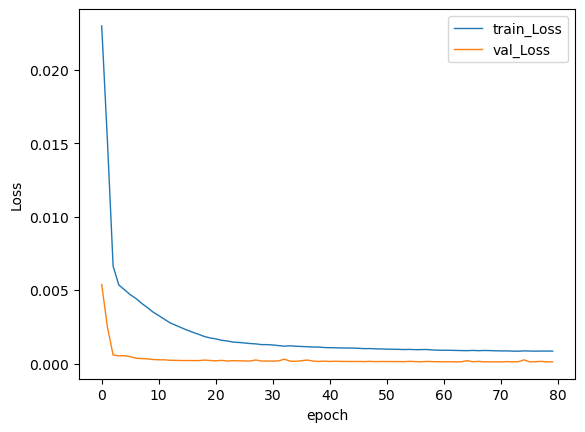

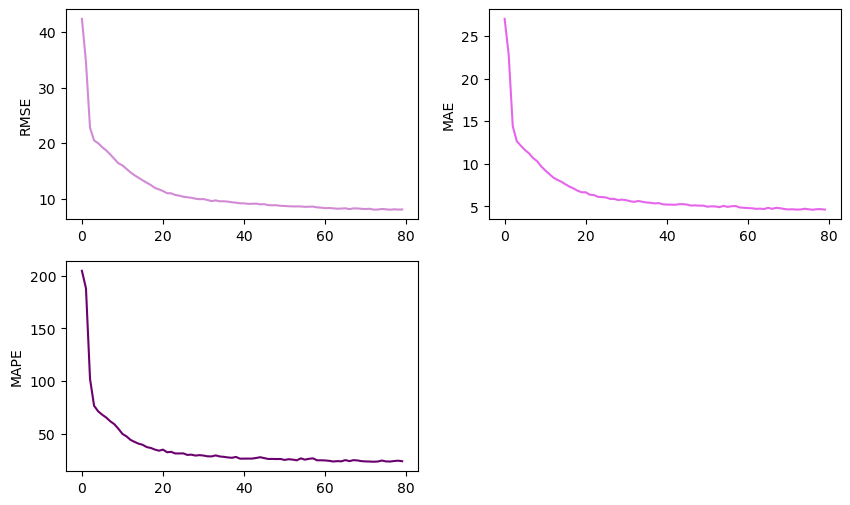

In [9]:
#第二部分：结果可视化
visualize(stop_epoch, train_loss_lst, val_loss_lst, y_label='Loss')
plot_metric(train_score_lst)